In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error
import pickle

In [3]:
from mlflow.tracking import MlflowClient
MLFLOW_TRACKING_URI = "sqlite:///duration_mlflow.db"
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [4]:
import mlflow
mlflow.set_tracking_uri("sqlite:///duration_mlflow.db")
mlflow.set_experiment("duration-experiment")

<Experiment: artifact_location='/Users/afrogrit/zoomcamp/MLOps/wk2/mlruns/1', creation_time=1685229105057, experiment_id='1', last_update_time=1685229105057, lifecycle_stage='active', name='duration-experiment', tags={}>

In [5]:
df = pd.read_parquet('./data/yellow_tripdata_2022-01.parquet')


# q1. Read the data for January. How many columns are there?
len(df. columns)




19

In [6]:
df.tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN
2463930,2,2022-01-31 23:46:00,2022-02-01 00:13:00,NaN,8.94,NaN,None,186,181,0,25.48,0.0,0.5,6.28,0.0,0.3,35.06,NaN,NaN


In [7]:
df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.total_seconds() / 60

"""
q2. compute the duration variable. It should contain the duration of a ride in minutes.
What's the standard deviation of the trips duration in January?
""" 
df.duration.std()

46.44530513776499

In [8]:
# axs[0].hist(dist1, bins=n_bins)
# sns.displot(df.duration)

In [9]:
# q.3: Fraction of the records left after dropping the outliers
((df.duration >= 1) & (df.duration <= 60)).sum() / len(df)

0.9827547930522406

In [10]:
# drop outiliers
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [11]:
categorical = ['PULocationID', 'DOLocationID']
df[categorical] = df[categorical].astype(str)

In [12]:
train_dicts = df[categorical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [13]:
# q.4. Dimensionality after OHE
X_train.shape

(2421440, 515)

In [14]:
# q.5: RMSE on train

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
mean_squared_error(y_train, y_pred, squared=False)

6.986190135970212

/Users/afrogrit/miniconda3/envs/zc-mlops/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/afrogrit/miniconda3/envs/zc-mlops/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


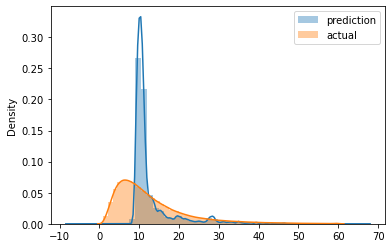

In [15]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()


In [16]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    # df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    # df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

df_train = read_dataframe('./data/yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2022-02.parquet')



In [17]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [18]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [19]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)


In [20]:
# q.6: RMSE on validation
mean_squared_error(y_val, y_pred, squared=False)

# Note: follow up on results

5.41512002191379

/Users/afrogrit/miniconda3/envs/zc-mlops/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/afrogrit/miniconda3/envs/zc-mlops/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


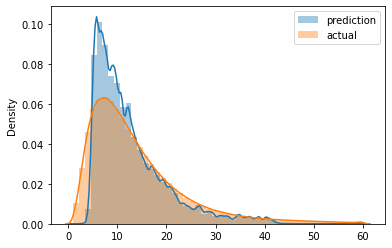

In [21]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_val, label='actual')
plt.legend()


### write model to local

In [22]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [23]:
!ls data/

yellow_tripdata_2022-01.parquet yellow_tripdata_2022-02.parquet


#### MLflow

initialize the run using

with `mlflow.start_run():`

We track the relevant information using three mlflow commands:

1. `set_tag`    - metadata tags
2. `log_param`  - logging model parameters
3. `log_metric` - logging model metrics

In [24]:
with mlflow.start_run():
    alpha = 0.1
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    mlflow.set_tag("developer", "sidewinder")
    mlflow.log_param("train-data-path", "./data/yellow_tripdata_2022-01.csv")
    mlflow.log_param("valid-data-path", "./data/yellow_tripdata_2022-02.csv")
    mlflow.log_param("alpha", alpha)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

In [31]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope


In [28]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

hyperopt Optimization objective inside a with mlflow.start_run() block, track every optimization run that was ran by hyperopt

In [29]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}


time constraint

In [32]:
# best_result = fmin(
#     fn=objective,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=50,
#     trials=Trials()
# )

[12:00:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:13.77670                          
[1]	validation-rmse:12.04798                          
[2]	validation-rmse:10.92094                          
[3]	validation-rmse:10.20674                          
[4]	validation-rmse:9.74615                           
[5]	validation-rmse:9.44669                           
[6]	validation-rmse:9.23720                           
[7]	validation-rmse:9.08533                           
[8]	validation-rmse:8.97116                           
[9]	validation-rmse:8.88287                           
[10]	validation-rmse:8.81244                          
[11]	validation-rmse:8.75026                          
[12]	validation-rmse:8.70160                          
[13]	validation-rmse:8.65156                          
[14]	validation

KeyboardInterrupt: 

In [33]:

with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[13:22:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.44423
[1]	validation-rmse:14.58602
[2]	validation-rmse:13.83718
[3]	validation-rmse:13.18436
[4]	validation-rmse:12.61383
[5]	validation-rmse:12.11949
[6]	validation-rmse:11.69070
[7]	validation-rmse:11.31937
[8]	validation-rmse:10.99635
[9]	validation-rmse:10.71761
[10]	validation-rmse:10.47711
[11]	validation-rmse:10.26515
[12]	validation-rmse:10.08603
[13]	validation-rmse:9.92909
[14]	validation-rmse:9.79424
[15]	validation-rmse:9.67206
[16]	validation-rmse:9.56904
[17]	validation-rmse:9.47682
[18]	validation-rmse:9.39350
[19]	validation-rmse:9.32160
[20]	validation-rmse:9.25854
[21]	validation-rmse:9.19958
[22]	validation-rmse:9.14912
[23]	validation-rmse:9.10295
[24]	validation-rmse:9.05900
[25]	validation-rmse:9.02083
[26]	validation-rmse:8.98666

/Users/afrogrit/miniconda3/envs/zc-mlops/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
